# Project Title:Customer Segmentation for E-commerce

## Project Overview

**Objective**: Summarize the goals of the analysis.

**Dataset Description**: Provide an overview of the dataset(s) used, including sources, variables, and key definitions.
Outline of Steps: Briefly outline the steps in the analysis process.

**Outline of Steps**: Briefly outline the steps in the analysis process.



In [1]:
#This bit of code allows me to output more than one variable value without using a print statement.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [3]:
%matplotlib inline
sns.set(style="whitegrid")
pd.options.display.max_columns = 50

### Data Loading 
**Load Dataset**: Use pandas to load data from various sources (e.g., CSV, Excel, SQL).

In [5]:
# Load dataset and get the 5 first rows
df = pd.read_excel(r"Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Check Data Types and Missing Values

In [7]:
# Remove rows with missing CustomerID
#Rows without CustomerID are removed because we need a customer ID to segment data by unique customers.
df.dropna(subset=['CustomerID'], inplace=True)

In [8]:

# Remove rows with negative values in Quantity or UnitPrice
#Rows with negative quantities or unit prices are likely errors (e.g., returns or cancellations), so we filter them out.
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Feature Engineering - Calculate TotalPrice and RFM Metrics
Feature engineering is the process of transforming raw data into meaningful inputs (features) that improve the clustering quality. Effective features help the algorithm better understand and separate different patterns or groups within the data.

#### Why Total Price?

1. Purchase Vlue : Represents the monetary value of each individual purchase made by a customer.
2. RFM Analysis : Measure how much each customer has spent in total over the observation period.
3. Clustering : Customers with higher TotalPrice values (indicating larger or more expensive purchases) are often more valuable to the business.

In [10]:
# Create a TotalPrice feature
df.loc[:, 'TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [12]:
# Define the latest date for recency calculation
import datetime as dt
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [13]:
print(latest_date)

2011-12-10 12:50:00


In [14]:
# Group by 'CustomerID' to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency (unique transactions)
    'TotalPrice': 'sum'                                      # Monetary (total spend)
}).copy()

In [15]:

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [17]:
# Segment Customers Using RFM Scores
#With the RFM DataFrame prepared, you can proceed to scaling and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Standardize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [18]:
# Fit KMeans clustering (choose 4 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

c:\Users\aekky\OneDrive\Documents\CODING\Python code\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\aekky\OneDrive\Documents\CODING\Python code\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python311\Lib\subprocess.

In [19]:

# Map clusters to segment labels for easier interpretation
segment_map = {
    0: 'Frequent Buyers',
    1: 'Low Engagement',
    2: 'New or Infrequent'
}
rfm['Segment'] = rfm['Cluster'].map(segment_map)

In [20]:
print(rfm)

            Recency  Frequency  Monetary  Cluster          Segment
CustomerID                                                        
12346.0         326          1  77183.60        1   Low Engagement
12347.0           2          7   4310.00        0  Frequent Buyers
12348.0          75          4   1797.24        0  Frequent Buyers
12349.0          19          1   1757.55        0  Frequent Buyers
12350.0         310          1    334.40        1   Low Engagement
...             ...        ...       ...      ...              ...
18280.0         278          1    180.60        1   Low Engagement
18281.0         181          1     80.82        1   Low Engagement
18282.0           8          2    178.05        0  Frequent Buyers
18283.0           4         16   2094.88        0  Frequent Buyers
18287.0          43          3   1837.28        0  Frequent Buyers

[4338 rows x 5 columns]


### Model Building

**K-Means Clustering**

### Model Evaluation

#### Evaluate performance

In [21]:
# Aggregation: Create RFM (Recency, Frequency, Monetary) features for each customer
# Represents the date on which we’re calculating Recency
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Recency: Days since last purchase
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #Recency
    'InvoiceNo': 'count', #Frequency
    'TotalPrice': 'sum' #Monetary
})

The resulting DataFrame `RFM` contains one row for each customer, with the following columns:
1. **Recency** : Days since the last purchase.
2. **Frequency** : Number of purchases.
3. **Monetary** : Total amount spent.

In [22]:
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# Standardize the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [23]:
# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'SSE (Sum of Squared Distances)')

Text(0.5, 1.0, 'Elbow Method For Optimal K')

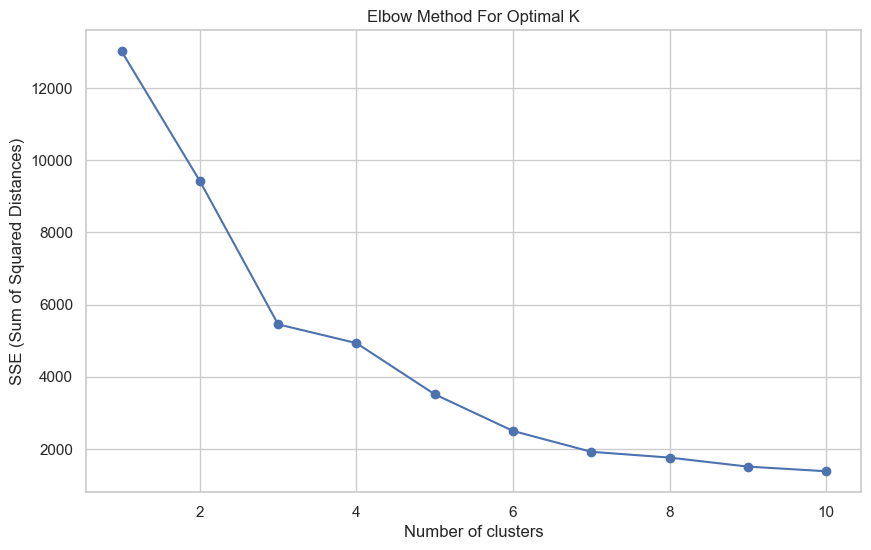

In [24]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE (Sum of Squared Distances)")
plt.title("Elbow Method For Optimal K")
plt.show()

### Compare  and Evaluating Model

To decide which cluster is better. Based on the graph on ELbow Method, we can choose either 3 cluster or 4 cluster based on Elbow Method.

In [25]:
#3 Cluster
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)

silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


            Recency    Frequency       Monetary
Cluster                                        
0         41.377196   103.089060    2028.833862
1        247.308333    27.787963     637.318510
2          4.692308  2565.307692  126118.310000
Silhouette Score: 0.60
Davies-Bouldin Index: 0.74


In [26]:
#4 Cluster
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

cluster_summary = rfm.groupby('Cluster').mean()
print(cluster_summary)

silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

            Recency    Frequency       Monetary
Cluster                                        
0         20.990788   135.285122    2645.818172
1         98.218703    37.719457     773.877083
2          4.692308  2565.307692  126118.310000
3        272.407005    25.138889     605.842525
Silhouette Score: 0.36
Davies-Bouldin Index: 0.92


### Visualization
Visualization of 3 cluster as the best model

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Recency')

Text(0, 0.5, 'Monetary')

Text(0.5, 1.0, 'Customer Segments Based on RFM')

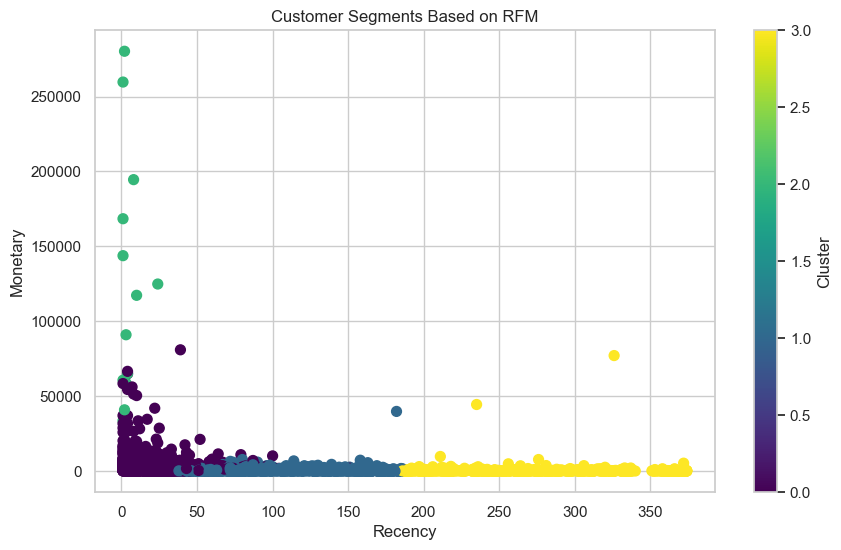

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments Based on RFM')
plt.colorbar(label='Cluster')
plt.show()

In [28]:
import pickle

# Assuming `kmeans` is your trained model and `scaler` is your fitted scaler
with open("kmeans_model.pkl", "wb") as model_file:
    pickle.dump(kmeans, model_file)

with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)


In [30]:
import joblib
joblib.dump(kmeans, "kmeans_model.pkl")

joblib.dump(kmeans, "scaler.pkl")

['kmeans_model.pkl']

['scaler.pkl']